# Selecting a Model

The goal of this notebook is to choose the best model for predicting scores of NCAA Tournament games. We will use the training data to run several machine learning models for our data. Finally, using the results, we select a modle to use for our NCAA Tournament predictions.

In [1]:
# Import packages
import sys
sys.path.append('../../')

import datetime
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import collegebasketball as cbb
cbb.__version__

'2022'

## Load the Data

First, we need to load the training data. This data set was built by creating feature vectors, removing games that don't accurately represent the NCAA Tournament games and reducing the number of features to a manageable number. More information about how this was done can be found in the Creating the Training Data, Covariate Shift Analysis and Feature Reduction notebooks. We'll split this data into training and test sets (with an even proportion of regular season and tournament games in each) so that we can tune the models with the training set before finally testing them with the test set.

In [2]:
# Load the csv files that contain the scores/kenpom data
path = '../../Data/Training/training_feat_reduced.csv'
training = pd.read_csv(path)
season = cbb.filter_tournament(training, drop=True)
march = cbb.filter_tournament(training)
exclude_cols = ['Favored', 'Underdog', 'Year', 'Tournament', 'Label']

# Get a sense for the size of each data set
print('Games in training data: {}'.format(len(training)))
print('Regular season games: {0}, Tournament games: {1}'.format(len(season), len(march)))

Games in training data: 14650
Regular season games: 14050, Tournament games: 600


In [3]:
# Split into train and test sets with an equal proportion of actual tournament games in each
season_train, season_test = train_test_split(season, random_state=77)
march_train, march_test = train_test_split(march, random_state=77)

train = pd.concat([season_train, march_train])
test = pd.concat([season_test, march_test])

print('Games in training set: {}'.format(len(train)))
print('Games in test set: {}'.format(len(test)))

Games in training set: 10987
Games in test set: 3663


## Logistic Regression Tuning

To start with, we'll try to tune some parameters for a logistic regression model. We'll try both Ridge and Lasso regression with different values for the `C` parameter (where a smaller value imposes a harsher penalty). To compare the different models, we'll run five fold cross validation on the test set and compare the average f1 and AUC scores across the different runs.

In [4]:
penalties = ['l1', 'l2']
c_values = [0.1, 1, 10, 50, 100]

cl_names = list()
clfs = list()
for p in penalties:
    for c in c_values:
        cl_names.append('log_reg_{0}_{1}'.format(p, c))
        clfs.append(LogisticRegression(penalty=p, C=c, solver='liblinear', random_state=77))

cbb.cross_val(train, exclude_cols, clfs, cl_names)

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,log_reg_l1_0.1,0.302714,0.340249,0.307851,0.320487,0.294235,0.313107
1,log_reg_l1_1,0.365759,0.371957,0.364694,0.345296,0.353488,0.360239
2,log_reg_l1_10,0.364341,0.377176,0.372361,0.345560,0.363299,0.364547
3,log_reg_l1_50,0.363636,0.378119,0.372361,0.349084,0.368178,0.366276
4,log_reg_l1_100,0.363636,0.378119,0.372004,0.349421,0.366327,0.365902
5,log_reg_l2_0.1,0.305931,0.326784,0.319672,0.304663,0.289133,0.309237
6,log_reg_l2_1,0.364356,0.368473,0.359726,0.340216,0.349953,0.356545
7,log_reg_l2_10,0.377691,0.375969,0.365759,0.345967,0.366512,0.366379
8,log_reg_l2_50,0.378537,0.374156,0.364694,0.350097,0.367688,0.367034
9,log_reg_l2_100,0.381413,0.376812,0.369942,0.345631,0.364815,0.367723


In [5]:
cbb.cross_val(train, exclude_cols, clfs, cl_names, scoring='roc_auc')

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,log_reg_l1_0.1,0.724025,0.699240,0.691655,0.702440,0.694534,0.702379
1,log_reg_l1_1,0.728627,0.708164,0.703997,0.700754,0.698454,0.707999
2,log_reg_l1_10,0.728233,0.708317,0.704799,0.700142,0.698375,0.707973
3,log_reg_l1_50,0.728160,0.709280,0.704842,0.699778,0.698279,0.708068
4,log_reg_l1_100,0.728132,0.709298,0.704845,0.699714,0.698397,0.708077
5,log_reg_l2_0.1,0.720457,0.695317,0.691627,0.701052,0.688896,0.699470
6,log_reg_l2_1,0.728528,0.706925,0.703481,0.701667,0.696334,0.707387
7,log_reg_l2_10,0.728579,0.707850,0.704614,0.699892,0.697004,0.707588
8,log_reg_l2_50,0.728820,0.708269,0.704568,0.699576,0.696844,0.707615
9,log_reg_l2_100,0.728501,0.708050,0.705009,0.699637,0.696961,0.707632


From the cross validation results above, I think both types of regularization penalties work well with a C value of 10. Since the chance of an upset is extremely variable, we want a robust model with a harsh enough regularization penalty, so I don't want the C value to be too high, but the f1 score does appear to increase as we increase C. I think 10 is a good middle ground and what we will use moving forward.

Below, we run train a model with each set of parameters on regular season data from the training data and evaluate them with the tournament data from the training set, just to see how well they seem to be able to predict tournament games. We can see that the performance is very similar between the two models, but there is a slight advantage for the Ridge Regression model.

In the end, the best logistic regression parameters for me are to use l2 regularization with a C value of 10. I think this will be the most robust logistic regression model we've tested here and we will compare it to the other algorithms later in the notebook.

In [6]:
clf_l2 = LogisticRegression(penalty='l2', C=10, solver='liblinear', random_state=77)
clf_l1 = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=77)
cbb.evaluate(season_train, march_train, exclude_cols, [clf_l2, clf_l1], ['L2 Penalty', 'L1 Penalty'])

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,L2 Penalty,0.500000,0.229358,0.314465,0.734779,0.163327,0.757778
1,L1 Penalty,0.490196,0.229358,0.312500,0.732008,0.164102,0.755556


## Random Forest Tuning

Next, we will follow a similar process to tune a random forest model. This time, we will be trying different values for the minimum number of samples to split, the maximum depth of trees and the maximum features used per tree. For reference, the default values in scikit-learn are 2, None and 'sqrt' respectively.

In [7]:
min_samples_splits = [2, 5, 10]
max_depths = [None, 25, 15]
max_features = ['sqrt', 'log2', 10]

cl_names = list()
clfs = list()
for s in min_samples_splits:
    for d in max_depths:
        for f in max_features:
            cl_names.append('rf_{0}_{1}_{2}'.format(s, d, f))
            clfs.append(RandomForestClassifier(min_samples_split=s, max_depth=d, max_features=f, 
                                               n_jobs=-1, random_state=77))

cross_val_result = cbb.cross_val(train, exclude_cols, clfs, cl_names)
cross_val_result

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,rf_2_None_sqrt,0.286229,0.288952,0.246068,0.257353,0.282741,0.272269
1,rf_2_None_log2,0.284404,0.274510,0.242537,0.260223,0.267951,0.265925
2,rf_2_None_10,0.294380,0.297911,0.271493,0.289331,0.290076,0.288638
3,rf_2_25_sqrt,0.296029,0.303309,0.246296,0.283623,0.275261,0.280904
4,rf_2_25_log2,0.256030,0.273585,0.250464,0.258364,0.287958,0.265280
5,rf_2_25_10,0.298748,0.302703,0.264253,0.284946,0.291312,0.288392
6,rf_2_15_sqrt,0.261860,0.269231,0.253788,0.254302,0.241224,0.256081
7,rf_2_15_log2,0.259716,0.264561,0.223735,0.239300,0.246550,0.246772
8,rf_2_15_10,0.269017,0.293785,0.257223,0.250235,0.286964,0.271445
9,rf_5_None_sqrt,0.285453,0.296846,0.260073,0.271809,0.268864,0.276609


In [8]:
cross_val_result = cbb.cross_val(train, exclude_cols, clfs, cl_names, scoring='roc_auc')
cross_val_result

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,rf_2_None_sqrt,0.583218,0.578027,0.563582,0.575798,0.569615,0.574048
1,rf_2_None_log2,0.574066,0.574220,0.564018,0.573494,0.568070,0.570774
2,rf_2_None_10,0.587130,0.585437,0.566015,0.580056,0.579016,0.579531
3,rf_2_25_sqrt,0.582239,0.580290,0.567900,0.584945,0.573208,0.577716
4,rf_2_25_log2,0.576208,0.572987,0.561835,0.575825,0.567494,0.570870
5,rf_2_25_10,0.585995,0.582536,0.563105,0.581095,0.577646,0.578076
6,rf_2_15_sqrt,0.598159,0.596776,0.584242,0.597314,0.579315,0.591161
7,rf_2_15_log2,0.606509,0.599328,0.583712,0.597333,0.584062,0.594189
8,rf_2_15_10,0.605062,0.604182,0.586051,0.597718,0.588239,0.596250
9,rf_5_None_sqrt,0.588709,0.590061,0.574136,0.582569,0.575039,0.582103


While there are a lot of results to process above, I found that some patterns emerged for each of the parameters we are tuning:
* min_samples_split: There is the least amount of consensus for this parameter, It seems like all of the options I tried worked well with at least some combination of the others. However, since 2 is the default, I will generally favor using that value.
* max_depth: It seems that generally the models with a larger maximum depth performance better. However, smaller and therefore simpler trees should be more robust, so I would like to use 25 as a maximum depth if possible.
* max_features: Generally, the models with more features performed better. Since there are a good number of features in this data set and we have already worked to try and reduce that number as much as possible, I think it is alright to use up to ten features for the trees.

Based on the trends above, I picked out some of the combinations of parameters to test them out on the training tournament data. Overall, I settled on using the default 2 for min_samples_split, a max depth of 25 and a max number of features of 10.

In [9]:
clf_2_None_10 = RandomForestClassifier(n_estimators=500, min_samples_split=2, max_depth=None, max_features=10, random_state=77)
clf_2_25_10 = RandomForestClassifier(n_estimators=500, min_samples_split=2, max_depth=25, max_features=10, random_state=77)
clf_5_None_10 = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_depth=None, max_features=10, random_state=77)
clf_10_25_10 = RandomForestClassifier(n_estimators=500, min_samples_split=10, max_depth=25, max_features=10, random_state=77)
clf_5_None_sqrt = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_depth=None, max_features='sqrt', random_state=77)
clf_10_15_sqrt = RandomForestClassifier(n_estimators=500, min_samples_split=10, max_depth=15, max_features='sqrt', random_state=77)

clfs = [clf_2_None_10, clf_2_25_10, clf_5_None_10, clf_10_25_10, clf_5_None_sqrt, clf_10_15_sqrt]
cl_names = ['rf_2_None_10', 'rf_2_25_10', 'rf_5_None_10', 'rf_10_25_10', 'rf_5_None_sqrt', 'rf_10_15_sqrt']
cbb.evaluate(season_train, march_train, exclude_cols, clfs, cl_names)

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,rf_2_None_10,0.382979,0.165138,0.230769,0.665851,0.180470,0.733333
1,rf_2_25_10,0.387755,0.174312,0.240506,0.663833,0.180978,0.733333
2,rf_5_None_10,0.365385,0.174312,0.236025,0.664075,0.180483,0.726667
3,rf_10_25_10,0.387755,0.174312,0.240506,0.667976,0.178581,0.733333
4,rf_5_None_sqrt,0.348837,0.137615,0.197368,0.667492,0.179263,0.728889
5,rf_10_15_sqrt,0.441176,0.137615,0.209790,0.684307,0.173666,0.748889


## Taking a Look at an XGBoost Model

Lastly, we will also take a look at using an XGBoost model. I have the least amount of familiarity with this type of model, so I'm just going to stick with the default values for now. Regardless, we'll run some cross validation and see how the model performs when trained on the regular season training data and tested on the march training data.

In [10]:
clf = XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='logloss', random_state=77)
cbb.cross_val(train, exclude_cols, [clf], ['XGBoost'])

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,XGBoost,0.333874,0.343671,0.313433,0.338141,0.350797,0.335983


In [11]:
cbb.cross_val(train, exclude_cols, [clf], ['XGBoost'], scoring='roc_auc')

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,XGBoost,0.587354,0.589086,0.57667,0.580571,0.584555,0.583647


In [12]:
cbb.evaluate(season_train, march_train, exclude_cols, [clf], ['XGBoost'])

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,XGBoost,0.318182,0.256881,0.284264,0.649358,0.227215,0.686667


## Selecting a ML Model

Now that we've found the set of ideal parameters for each of the algorithms we'll be testing, we can compare the results of training each on the training data and then testing on the test data.

In [13]:
# Create the models
log = LogisticRegression(penalty='l2', C=10, solver='liblinear', random_state=77)
rf = RandomForestClassifier(n_estimators=500, max_depth=25, max_features=10, random_state=77)
xgb = XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='logloss', random_state=77)

clfs = [log, rf, xgb]
cl_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

cbb.evaluate(season, march, exclude_cols, clfs, cl_names)

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,Logistic Regression,0.549296,0.250000,0.343612,0.741713,0.166534,0.751667
1,Random Forest,0.391304,0.173077,0.240000,0.680888,0.183794,0.715000
2,XGBoost,0.386792,0.262821,0.312977,0.668933,0.221983,0.700000


The results above show that the Logistic Regression model is performing best when we look at precision, recall, f1 and AUC scores. Interestingly, the other models both have a higher Brier score, which could indicate that while they're prediction may be less accurate, they are generating better probability values.

Before definitively selecting one of these models, I also want to drill down a little more specifically on how well the models are able to predict NCAA Tournament games. After all, that is the goal of this project. In order to gauge the models' accuracy for those games, I've developed a version of cross validation that I like to call "leave march out" cross validation. The idea is to leave the games from one year's NCAA Tournament aside per fold, train the models on the rest of the data and then test them on that year's set of tournament games. This way, each fold is using most of the data we have for training and testing on a smaller set of games that are all NCAA Tournament games. The output shows how well the model performed on the games from each year's NCAA Tournament.

In [14]:
cv_results, log_data = cbb.leave_march_out_cv(season, march, exclude_cols, log)
cv_results

,Precision,Recall,F1,AUC,Brier,Accuracy
Classifier,,,,,,
2010,0.285714,0.125000,0.173913,0.686198,0.174717,0.703125
2011,0.444444,0.210526,0.285714,0.664474,0.197571,0.701493
2012,0.700000,0.411765,0.518519,0.788235,0.153985,0.805970
2013,0.666667,0.235294,0.347826,0.735294,0.166909,0.776119
2014,1.000000,0.291667,0.451613,0.856589,0.164499,0.746269
2015,0.500000,0.285714,0.363636,0.716981,0.150936,0.791045
2016,0.300000,0.214286,0.250000,0.650943,0.172578,0.731343
2017,0.800000,0.235294,0.363636,0.791765,0.150621,0.791045
2018,0.500000,0.222222,0.307692,0.758503,0.163731,0.731343


In [15]:
cv_results, rf_data = cbb.leave_march_out_cv(season, march, exclude_cols, rf)
cv_results

,Precision,Recall,F1,AUC,Brier,Accuracy
Classifier,,,,,,
2010,0.333333,0.062500,0.105263,0.699219,0.171951,0.734375
2011,0.500000,0.210526,0.296296,0.631579,0.204803,0.716418
2012,0.625000,0.294118,0.400000,0.728235,0.169946,0.776119
2013,0.333333,0.176471,0.230769,0.594118,0.210633,0.701493
2014,0.909091,0.416667,0.571429,0.840116,0.169989,0.776119
2015,0.500000,0.214286,0.300000,0.700809,0.159999,0.791045
2016,0.200000,0.142857,0.166667,0.551213,0.195736,0.701493
2017,0.300000,0.176471,0.222222,0.737647,0.174721,0.686567
2018,0.400000,0.111111,0.173913,0.690476,0.177947,0.716418


In [16]:
cv_results, xgb_data = cbb.leave_march_out_cv(season, march, exclude_cols, xgb)
cv_results

,Precision,Recall,F1,AUC,Brier,Accuracy
Classifier,,,,,,
2010,0.111111,0.062500,0.080000,0.587240,0.258958,0.640625
2011,0.400000,0.315789,0.352941,0.630482,0.244535,0.671642
2012,0.500000,0.235294,0.320000,0.702353,0.186709,0.746269
2013,0.166667,0.117647,0.137931,0.565882,0.273225,0.626866
2014,0.866667,0.541667,0.666667,0.818798,0.164514,0.805970
2015,0.363636,0.285714,0.320000,0.756065,0.168023,0.746269
2016,0.200000,0.214286,0.206897,0.540431,0.249757,0.656716
2017,0.307692,0.235294,0.266667,0.712941,0.230898,0.671642
2018,0.500000,0.222222,0.307692,0.699546,0.197052,0.731343


The above results support out finding from using the training and test sets - the logistic regression model is performing best by each metric except the Brier score.

I think it's important to select a model that is able to generate useful prediction probabilities. Since the NCAA Tournament notoriously has so many upsets, I want to be sure that my model will predict enough upsets. To achieve this goal, I've found that in the past, I had to lower the threshold for an upset form the usual probability of 0.5, to something lower and in order for this technique to be effective, we need a model that is generating accurate probability values. 

One method to evaluate these probabilities is to use something like the Brier score used above or another similar method like Log Loss. However, I also wanted to use a more visual method to examine these probabilities closer. To do this, I used a binning method to group sets of games by the predicted probability of an upset assigned by a given model. Then I calculate the actual fraction of upsets in each bin and plotted the results. Ideally, if the model assigned a probability between 0.5 and 0.55 for a set of games, something like 55% of the games should have resulted in an upset. The closer that the resulting plots follow a slope of 1.0, the better it would appear that the model is predicting probabilities.

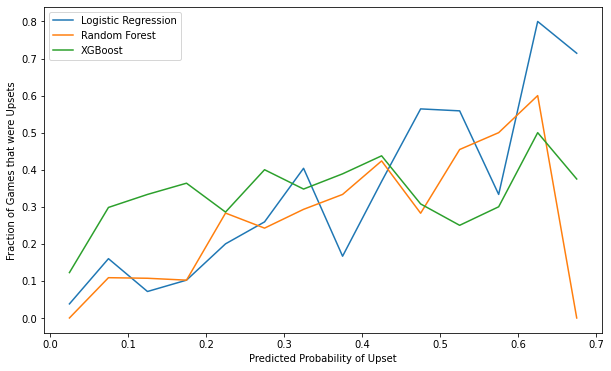

In [17]:
probs = [log_data['Probability'], rf_data['Probability'], xgb_data['Probability']]
cbb.probability_graph(log_data['Label'], probs, cl_names, figsize=(10, 6))

The results above show that the logistic regression and random forest models are producing better probabilities, which is directly at odds with the Brier scores we saw above. The chances a game is an upset seems to stay relatively level regardless of what the XGBoost model actually predicted as the predicted probability.

Overall, I think I will go with the logistic regression model this year because it had the best performance by most metrics, is the simplest and seems to have relatively useful probability scores.